# Pricing Interest Rate Swaps & Calculating XVAs

********

We continue with the previously established interest rate setup. That is, we consider a market where we have established at time $0$ (e.g., by looking at quoted swap and futures prices) that the risk-free forward interest rate curve is given by 

$$f(0,t) = a + b.t$$

where $a=2.5\%\;\&\;b = 0.2\%$

The dynamics of the forward curve $f(t,T)$ are the same as well: a 2-factor Gaussian model with $\sigma_{r}=2\%, c=40\%, \kappa_{2}=5\%, \rho_{\infty}=40\%$

The instrument we are dealing with also remains the same: a 10-year semi-annual interest rate swap with a notional value $USD\;50$ million and coupon $h$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import cos, exp, pi
from scipy.optimize import fsolve
import random
from scipy.stats import norm

In [2]:
class SwapPricer:
    
    def __init__(self,a,b,c,rho_inf,sig_r,k2,N,T_,ts_):
        self.a       =  a
        self.b       =  b
        self.c       =  c
        self.rho_inf =  rho_inf
        self.sig_r   =  sig_r
        self.k2      =  k2
        self.sig1    =  self.c * self.sig_r
        self.v       =  np.sqrt((1/self.c)**2 - 1 - 2*((self.rho_inf/self.c) - 1))
        self.sig2    =  self.v * self.sig1
        self.px      =  ((self.rho_inf/self.c) - 1)/(self.v)
        self.N       =  N
        self.T_      =  T_
        self.ts_     =  ts_
        self.dt_     =  self.T_[1] - self.T_[0]
    
    
    def y_mat(self,t_):
        y1 = (self.sig1**2)*t_ + \
        ( ( (self.px**2) * (self.sig1**2) * (self.sig2**2) * (np.exp(2*self.k2*t_) - 1) ) / (2*self.k2) )   
        
        y2 = (((self.sig1**2)*(self.sig2)*self.px )*( np.exp(self.k2*t_) - 1 ) + \
              ( (self.sig2**2) * (self.sig1) * (self.px)) * (np.exp(2*self.k2*t_) - 1)) * np.exp(-self.k2*t_)
        
        y3 = y2
        
        y4 = (((self.sig2**2)*(1 - np.exp(-2*k2*t_)))/(2*self.k2)) + \
        (((self.px**2) * (self.sig1**2) * (self.sig2**2)) * (1 - np.exp(-2*self.k2*t_)))/(2*self.k2)
        
        return y1, y2, y3, y4
    
    
    def simulations(self):
        X1 = np.zeros((self.N,len(self.ts_)))
        X2 = np.zeros((self.N,len(self.ts_)))
        X1[:,0] = 0
        X2[:,0] = 0
        
        dt = self.ts_[1] - self.ts_[0]
        dWx1 = np.random.normal(loc = 0,scale=np.sqrt(dt),size=(self.N,len(self.ts_)-1))
        dWx2 = np.random.normal(loc = 0,scale=np.sqrt(dt),size=(self.N,len(self.ts_)-1))
        dWx2 = self.px*dWx1 + dWx2*np.sqrt(1 - (self.px)**2)
        
        for i in range(0,len(self.ts_)-1):
            l0,l1,l2,l3 = self.y_mat(self.ts_[i])
            X1[:,i+1] = X1[:,i] + (l0 + l1)*dt + self.sig1*dWx1[:,i]
            X2[:,i+1] = X2[:,i] + (l2 + l3 - (self.k2*X2[:,i]))*dt + self.sig2*dWx2[:,i]
        
        return X1,X2
    
    
    def Plot(self,x1_,x2_):
        figure, axis = plt.subplots(2,1)
        figure.set_figwidth(20)
        figure.set_figheight(10)
        
        for i in range(self.N):
            axis[0].plot(self.ts_,x1_[i,:])
        axis[0].set_title("Two Factor OU Process")
        axis[0].set_ylabel("X1")
        axis[0].set_xlabel("Years")
        axis[0].grid(True)

        for i in range(self.N):
            axis[1].plot(self.ts_,x2_[i,:])
        axis[1].set_xlabel("Years")
        axis[1].set_ylabel("X2")
        axis[1].set_title("Two Factor OU Process")
        axis[1].grid(True)
        plt.show()
    
    
    def A_vec(self,t_):
        v1, v2, v3, v4 = self.y_mat(t_)
        Ttemp = self.T_[self.T_ > t_]
        ttemp = np.ones(len(Ttemp))*t_
        Tdelt = Ttemp - ttemp
        return -0.5*((Tdelt)**2)*v1 - \
        (v3/self.k2)*(Tdelt)*(1-np.exp(-self.k2*(Tdelt))) - \
    0.5*(v4/(self.k2)**2)*(1 - np.exp(-self.k2*(Tdelt)))**2
    
    
    def Pr(self,t_,x1_,x2_):
        Ttemp = self.T_[self.T_ > t_]
        ttemp = np.ones(len(Ttemp))*t_
        T_t = np.tile(Ttemp - ttemp, (self.N,1))
        A = np.tile(self.A_vec(t_), (self.N,1))
        P_0T = np.tile(np.exp(-(self.a*Ttemp + self.b*(Ttemp**2)/2)), (self.N,1))
        P_0t = np.tile(np.exp(-(self.a*ttemp + self.b*(ttemp**2)/2)), (self.N,1))
        t_index = np.where(self.ts_==t_)[0][0]
        CX   = x1_[:,t_index].reshape((self.N,1))*(-T_t) + \
        x2_[:,t_index].reshape((self.N,1))*(np.exp(-self.k2*(T_t)) - 1) / (self.k2)
        
        return (P_0T / P_0t) * np.exp(A + CX)
    
    
    def spot_rate(self,x1_,x2_):
        f_0t = np.tile(self.a + self.b*self.ts_,(self.N,1))
        return f_0t + x1_ + x2_
    
    
    def beta(self,t_,x1_,x2_):
        t_index = np.where(self.ts_==t_)[0][0]
        h = (t_-0)/(len(self.ts_[:t_index+1]))
        r = self.spot_rate(x1_,x2_)
        rt = r[:,:t_index+1]
        return np.exp((h/2)*(rt[:,0] + 2*np.sum(rt[:,1:len(rt)-1], axis=1) + rt[:,-1]))

    
    def StubVal(self,t_,x1_,x2_):
        if t_ in self.T_:
            return np.ones(self.N)
        else:    
            T0 = self.T_[self.T_ < t_][-1]
            return self.beta(t_,x1_,x2_) / self.beta(T0,x1_,x2_) 
    
    
    def SwapVal(self,x1_,x2_,c):
        swap = np.zeros((self.N,len(self.ts_)))
        for i in range(len(self.ts_)-1):
            disc_fact = self.Pr(self.ts_[i],x1_,x2_)
            agg_disc_fact = np.sum(disc_fact, axis=1) * c * self.dt_
            stub = self.StubVal(self.ts_[i],x1_,x2_)
            final_term = disc_fact[:,-1] 
            swap_value = agg_disc_fact - stub + final_term
            swap[:,i] = swap_value
        return swap
    

In [3]:
# MODEL PARAMETERS

a       = 0.025
b       = 0.002
sig_r   = 0.02
c       = 0.4
k2      = 0.05
rho_inf = 0.4

In [4]:
# OBSERVATION GRID
ts = np.arange(0,521)/52   # WEEKLY GRID

In [5]:
# SWAP DEFINITION

notional = 50000000         # SWAP NOTIONAL
maturity = 10               # MATURITY (in Yrs.)
T = np.linspace(0,10,21)    # PAYMENT DATES (in Yrs.)

In [6]:
# NO OF SIMULATIONS
N = 30000

In [7]:
model1 = SwapPricer(a,b,c,rho_inf,sig_r,k2,N,T,ts)
x1, x2 = model1.simulations()
#model1.Plot(x1,x2)

In [8]:
# FINDING h_par

def optimal_h(c):
    swap_price = model1.SwapVal(x1,x2,c)[0][0]
    return swap_price

h_par = fsolve(func=optimal_h, x0=0)[0]
print("Optimal value for coupon is :", h_par)

Optimal value for coupon is : 0.034721066827000255


*******

We repeat the exercise of plotting the expected exposure (EE) profile for uncollateralized par-valued payer and receiver swaps, on a weekly grid spanning $[0,10yrs]$ using coupons of $h = 2\%, h = 4\%, h = 6\%, h = 8\%$ for both - payer and receiver swap.

### Review

In a Cox process setting, using the results for Recovery Amount Pricing, a contract paying some possibly stochastic amount $Y(\tau)$ at the time of default, provided default takes place before time $T$ will have the time $0$ value of 

$$\mathop{\mathbb{E}}\left(1_{\tau < T}Y(\tau)e^{-\int_{0}^{\tau}r(u)du}\right) = \mathop{\mathbb{E}}\left( \int_{0}^{T} Y(s)e^{-\int_{0}^{s}r(u)du}\lambda(s)e^{-\int_{0}^{s}\lambda(u)du}ds\right)$$

Second, if we have a portfolio of trades in a netting set, we can associate it with an exposure variable $E(t)$, which is the amount that is at risk if there is a default and the portfolio is settled at time $t$.

For instance, if the portfolio value (to us) is $V(t)$, and there is no collateral, then $E(t) = V(t)^{+}$.

We can define PV-ed and un-PV’ed expected exposures as

$$EE(t) = \mathop{\mathbb{E}}(E(t)),\;\;\;PVEE(t) = \mathop{\mathbb{E}}\left( E(t)e^{-\int_{0}^{t}r(u)du} \right)$$

In [9]:
h1 = np.array([0.02,0.04,0.06,0.08])

In [10]:
model3 = SwapPricer(a,b,c,rho_inf,sig_r,k2,N,T,ts)
x1_3, x2_3 = model3.simulations()
rates3 = model3.spot_rate(x1_3,x2_3)
#model3.Plot(x1_3, x2_3)

In [11]:
swap_prices_ = np.zeros(len(h1), dtype=object)
swap_prices_delta = np.zeros(len(h1), dtype=object)
pEE = np.zeros((len(h1),len(ts)), dtype=object)
rEE = np.zeros((len(h1),len(ts)), dtype=object)
pPVEE = np.zeros((len(h1),len(ts)), dtype=object)
rPVEE = np.zeros((len(h1),len(ts)), dtype=object)
pEE_VM = np.zeros((len(h1),len(ts)), dtype=object)
rEE_VM = np.zeros((len(h1),len(ts)), dtype=object)
pPVEE_VM = np.zeros((len(h1),len(ts)), dtype=object)
rPVEE_VM = np.zeros((len(h1),len(ts)), dtype=object)
pEE_VM_IM = np.zeros((len(h1),len(ts)), dtype=object)
rEE_VM_IM = np.zeros((len(h1),len(ts)), dtype=object)
pPVEE_VM_IM = np.zeros((len(h1),len(ts)), dtype=object)
rPVEE_VM_IM = np.zeros((len(h1),len(ts)), dtype=object)

In [12]:
def disc_factor(ts_):
    disc_factors = np.ones((N,len(ts_)))
    #rates = model3.spot_rate(x1_3,x2_3)[:,:np.where(ts==t)[0][0]+1]
    for i in range(len(ts_)):
        r = rates3[:,:np.where(ts_==ts_[i])[0][0]+1]
        h = (ts_[i]-0)/(len(ts_[:np.where(ts_==ts_[i])[0][0]+1]))
        disc_factors[:,i] = np.exp(-(h/2)*(r[:,0] + 2*np.sum(r[:,1:len(r)-1],axis=1) + r[:,-1]))
        
    return disc_factors

dfac = disc_factor(ts)
#dfac

In [13]:
p0 = 0.99
psi_p0 = (norm.pdf(norm.ppf(p0)) - norm.ppf(p0)*(1-p0))*np.sqrt(2*np.pi)
    
for i in range(len(h1)):
    swap_prices_[i] = model3.SwapVal(x1_3,x2_3,h1[i]) * notional
    spd = np.roll(swap_prices_[i], 2, axis=1)
    spd[:,:2] = np.zeros((len(spd),2))
    swap_prices_delta[i] = spd
    
    # Payer & Receiver EE(t) with no collateral
    pEE[i] = np.mean(np.maximum(-swap_prices_[i],0),axis=0)
    rEE[i] = np.mean(np.maximum(swap_prices_[i],0),axis=0)
    # Payer & Receiver PVEE with no collateral
    pPVEE[i] = np.mean(np.maximum(-swap_prices_[i],0)*dfac,axis=0) 
    rPVEE[i] = np.mean(np.maximum(swap_prices_[i],0)*dfac,axis=0) 
    # Payer & Receiver EE(t) with VM
    pEE_VM[i] = np.mean(np.maximum(-(swap_prices_[i]-swap_prices_delta[i]),0),axis=0) 
    rEE_VM[i] = np.mean(np.maximum((swap_prices_[i]-swap_prices_delta[i]),0),axis=0) 
    # Payer & Receiver PVEE with VM
    pPVEE_VM[i] = np.mean(np.maximum(-(swap_prices_[i]-swap_prices_delta[i])*dfac,0),axis=0) 
    rPVEE_VM[i] = np.mean(np.maximum((swap_prices_[i]-swap_prices_delta[i])*dfac,0),axis=0) 
    # Payer & Receiver EE(t) with VM & IM
    pEE_VM_IM[i] = np.mean(np.maximum(-(swap_prices_[i]-swap_prices_delta[i]),0),axis=0) * psi_p0
    rEE_VM_IM[i] = np.mean(np.maximum(swap_prices_[i]-swap_prices_delta[i],0),axis=0) * psi_p0
    # Payer & Receiver PVEE with VM & IM
    pPVEE_VM_IM[i] = np.mean(np.maximum(-(swap_prices_[i]-swap_prices_delta[i]),0)*dfac,axis=0) * psi_p0 
    rPVEE_VM_IM[i] = np.mean(np.maximum(swap_prices_[i]-swap_prices_delta[i],0)*dfac,axis=0) * psi_p0 

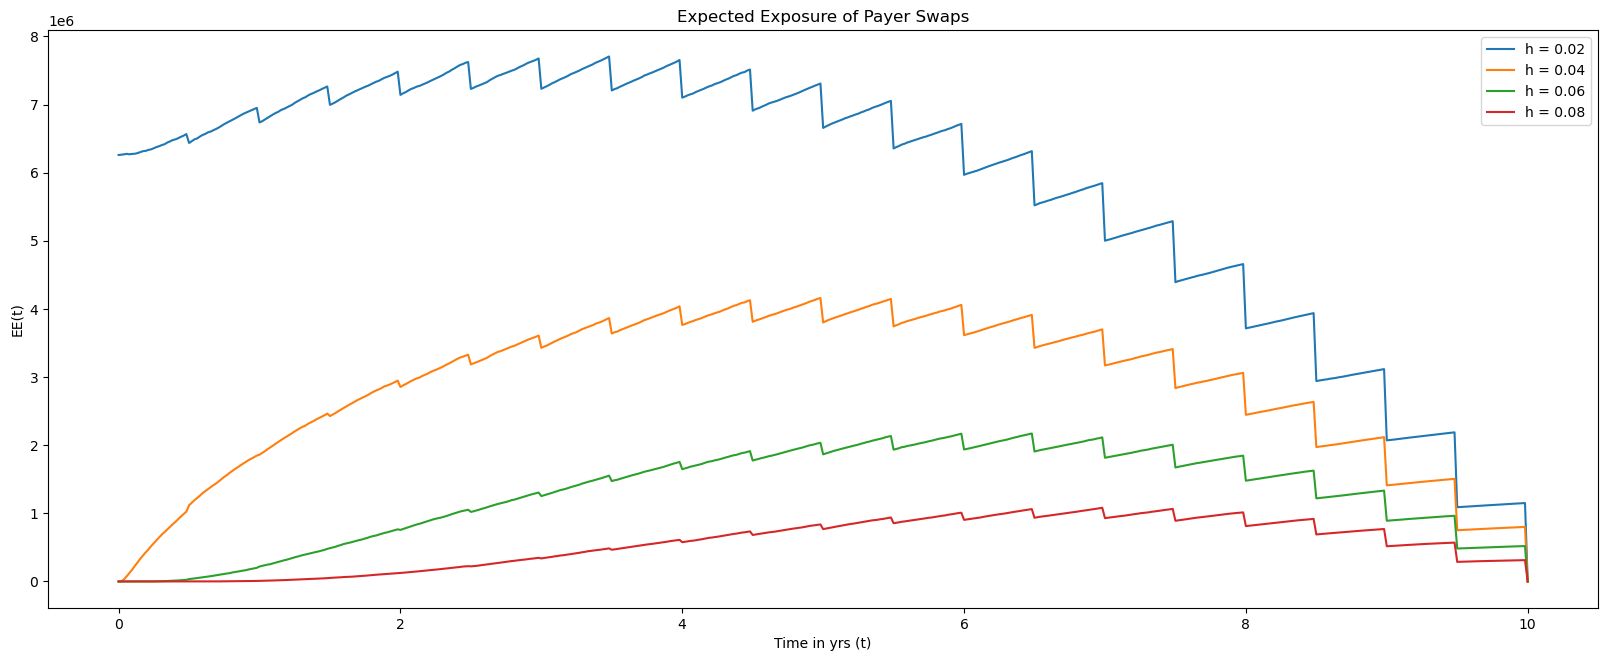

In [14]:
plt.figure(figsize=(20,7.5))
plt.title("Expected Exposure of Payer Swaps")
plt.xlabel("Time in yrs (t)")
plt.ylabel("EE(t)")

for i in range(len(h1)):
    plt.plot(ts, pEE[i], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

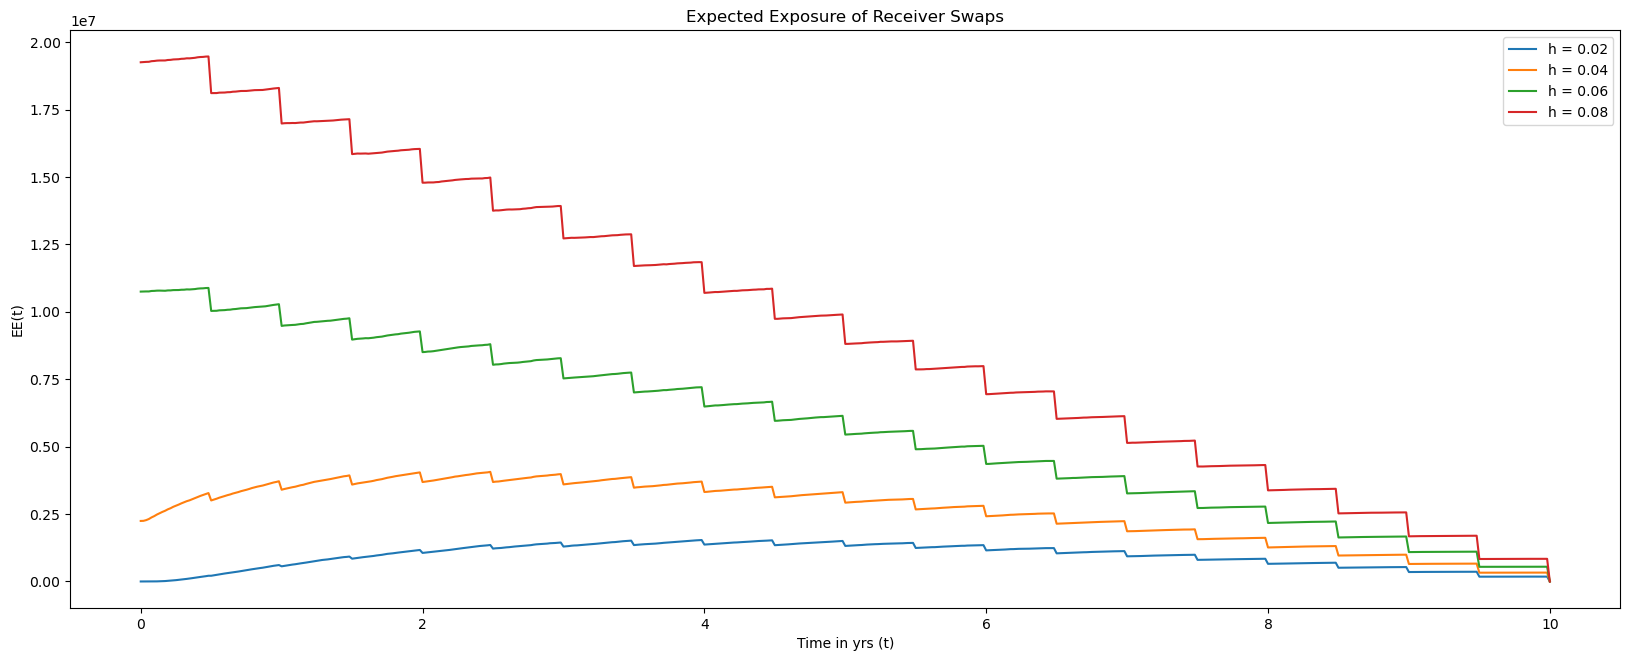

In [15]:
plt.figure(figsize=(20,7.5))
plt.title("Expected Exposure of Receiver Swaps")
plt.xlabel("Time in yrs (t)")
plt.ylabel("EE(t)")

for i in range(len(h1)):
    plt.plot(ts, rEE[i], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

We now do the PVEE profiles, rather than the EE profiles.

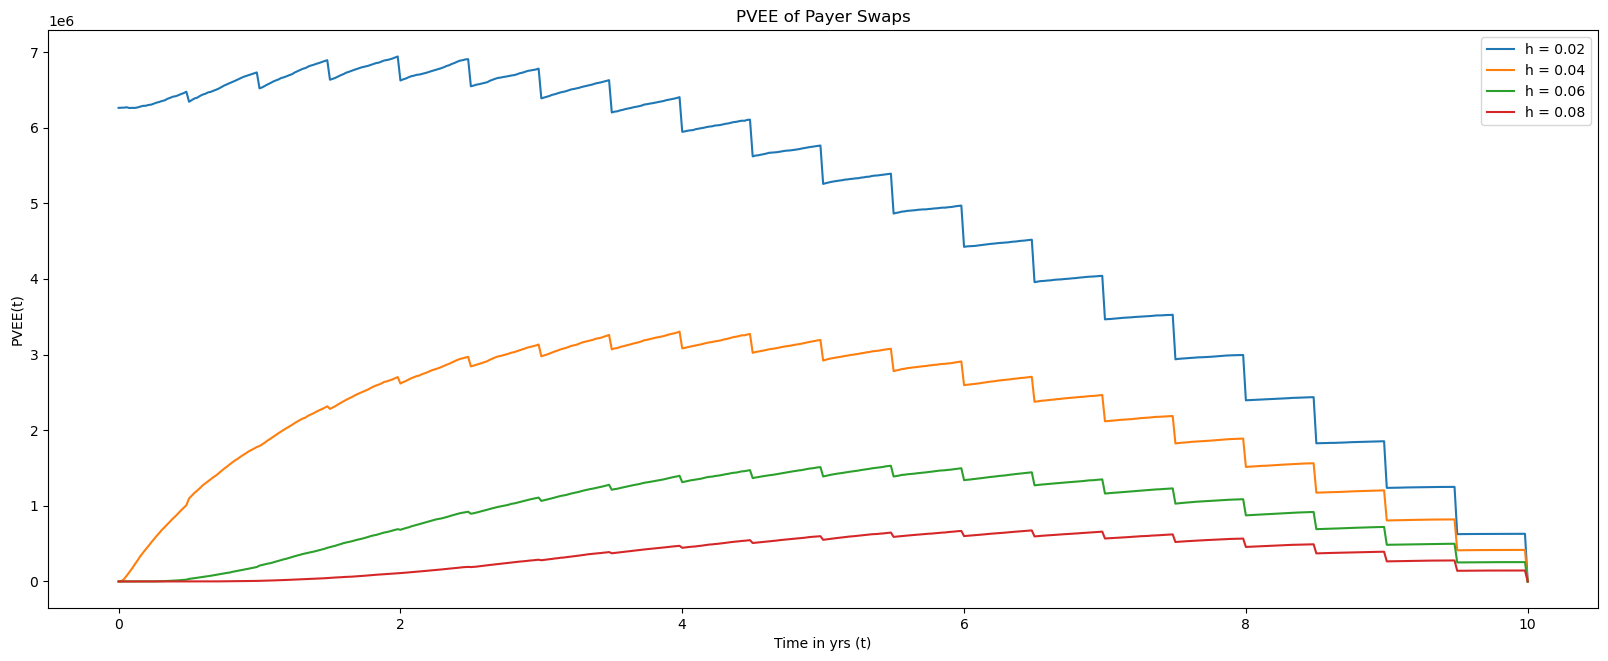

In [16]:
plt.figure(figsize=(20,7.5))
plt.title("PVEE of Payer Swaps")
plt.xlabel("Time in yrs (t)")
plt.ylabel("PVEE(t)")

for i in range(len(h1)):
    plt.plot(ts, pPVEE[i], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

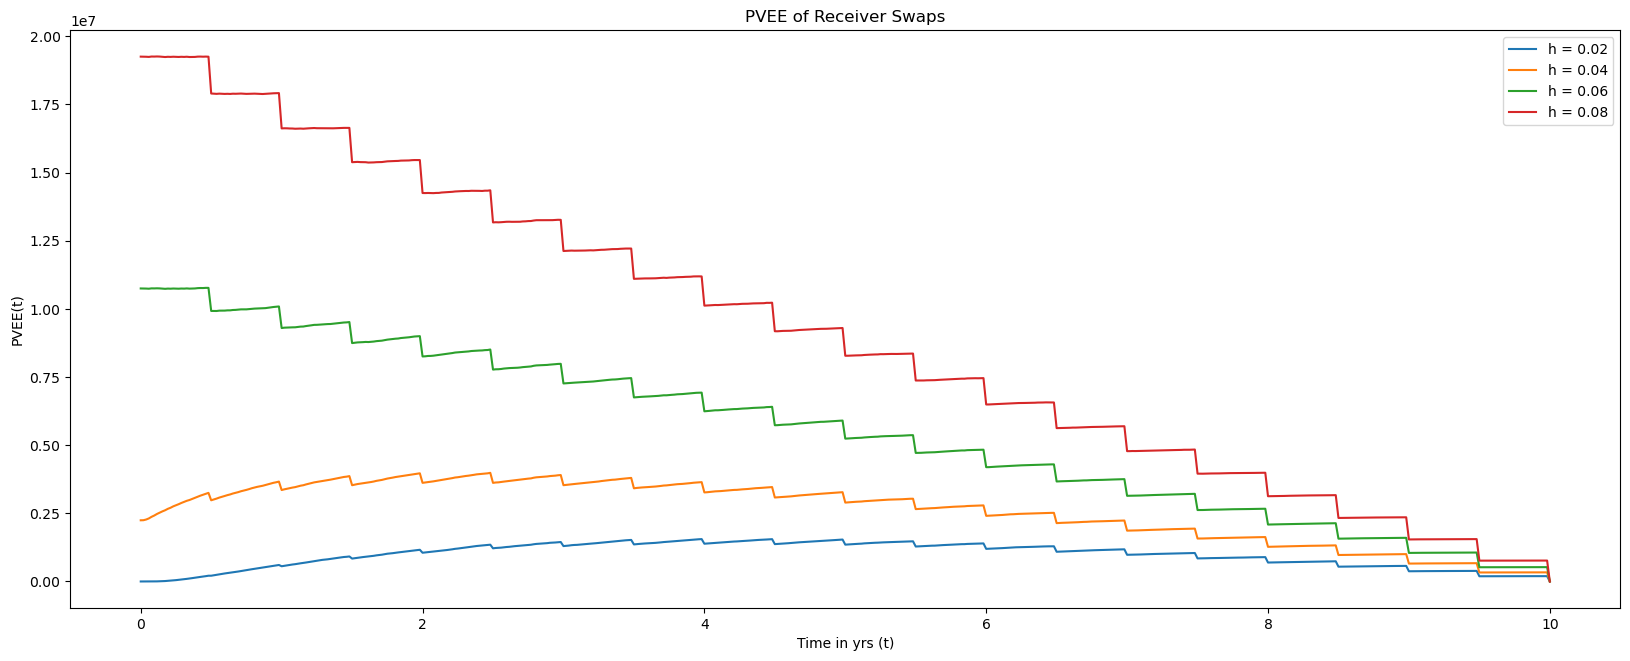

In [17]:
plt.figure(figsize=(20,7.5))
plt.title("PVEE of Receiver Swaps")
plt.xlabel("Time in yrs (t)")
plt.ylabel("PVEE(t)")

for i in range(len(h1)):
    plt.plot(ts, rPVEE[i], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

In our previous calculatins, there was no collateral. We now change this to assume that there is full variation margin (but no initial margin). Also assume that the swap is traded on an ISDA Master Agreement, and assume that the Margin Period of Risk (MPoR) is estimated at $\delta = 0.5$ months (so roughly 2 weeks). You can ignore complications from any unpaid cash flows, i.e. exposure for settlement time $t$ is $E(t) = (V(t)− V(t−\delta))^{+}$

### Review:
**Variation Margin (VM)** is posted to track moves in the value of the underlying portfolio, making sure that the exposure originating from directional moves are not allowed to grow too big. 

A common standard these days for VM is to demand full VM, in the sense that the VM at all times are computed to simply equal the portfolio value $V$. 

Without an MPoR lag, such full VM would result in no credit risk – but this is obviously too optimistic in an ISDA MA setting. Indeed, given the lags of the ISDA MA and of the CSA posting schedule (and assuming that no VM is posted on the MPoR), we can write -

$$VM(t) = V(t-\delta)$$
where $\delta$ is the MPoR lag.



**Initial Margin (IM)** is an additional buffer that covers against adverse moves of the portfolio on the MPoR.

Unlike VM, IM is not posted directly between counterparties (and therefore cannot be rehypothecated). Instead, it is posted to a third-party custodian.

The regulatory rule is roughly that IM must be set as the 99% VaR of $V(t)-V(t-\delta)$, with $\delta$=10 bdays.

ISDA has defined a standard VaR calculator for everybody to use in margin calculations in order to avoid disputes in calculations of counterparties. This is known a **Standard Initial Margin Model (SIMM)**.

Let's compute and graph the EE and PVEE profiles (weekly spacing) for the collateralized payer and receiver swaps.

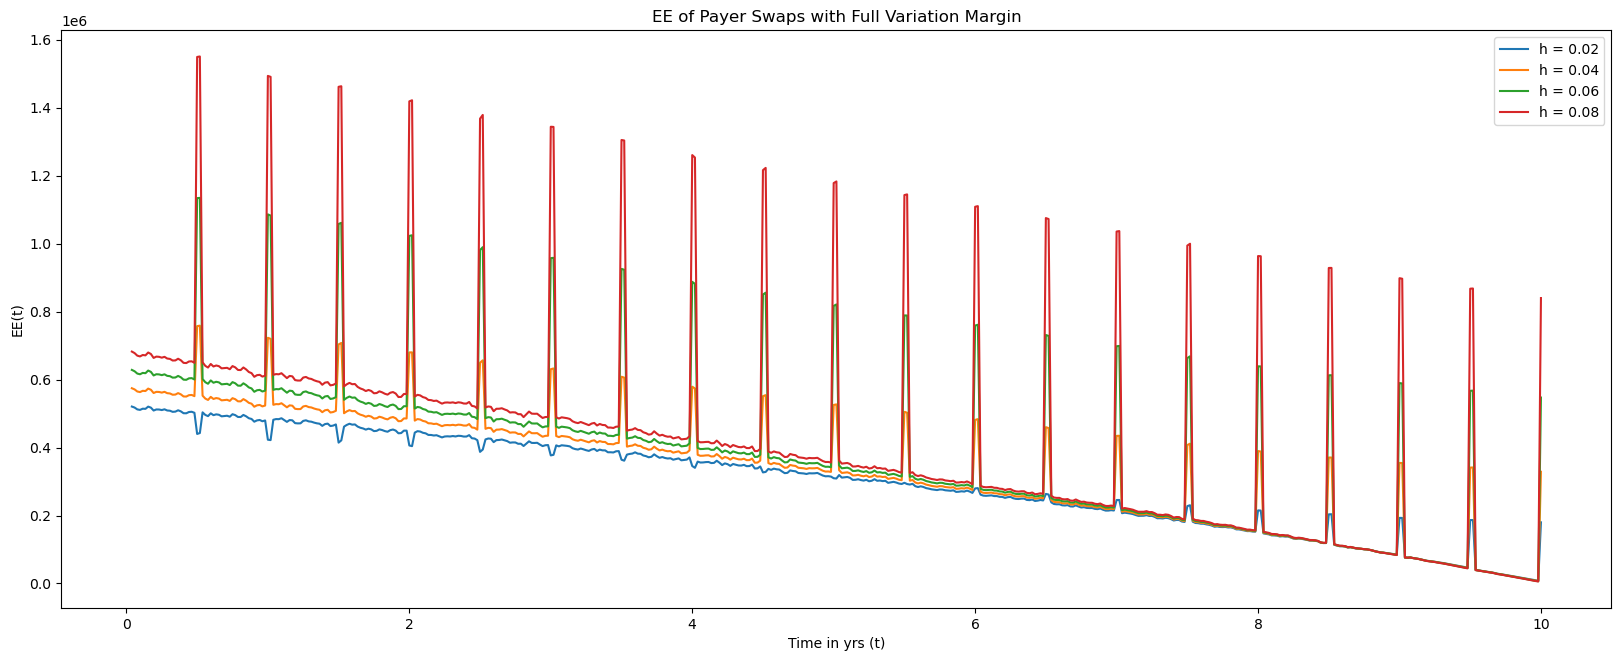

In [18]:
plt.figure(figsize=(20,7.5))
plt.title("EE of Payer Swaps with Full Variation Margin")
plt.xlabel("Time in yrs (t)")
plt.ylabel("EE(t)")

for i in range(len(h1)):
    plt.plot(ts[2:], pEE_VM[i][2:], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

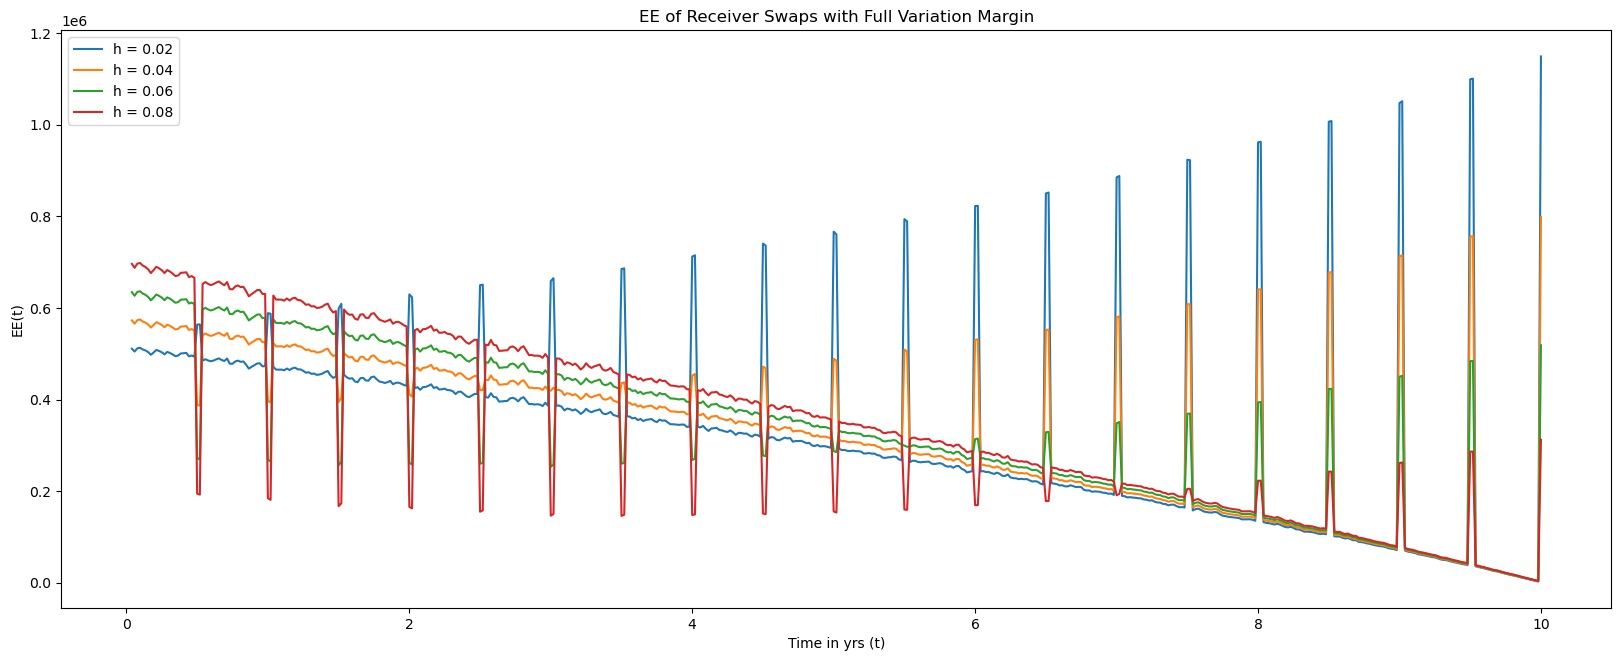

In [19]:
plt.figure(figsize=(20,7.5))
plt.title("EE of Receiver Swaps with Full Variation Margin")
plt.xlabel("Time in yrs (t)")
plt.ylabel("EE(t)")

for i in range(len(h1)):
    plt.plot(ts[2:], rEE_VM[i][2:], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

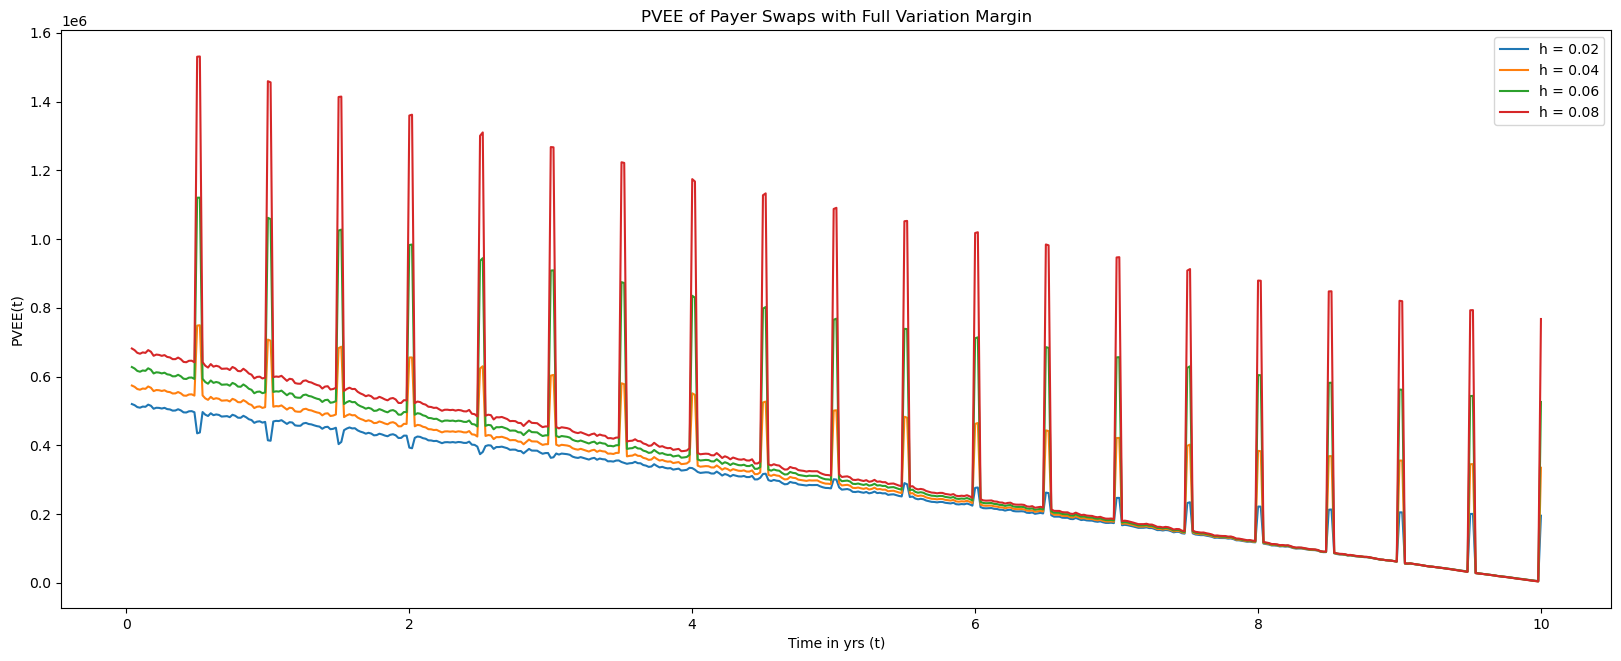

In [20]:
plt.figure(figsize=(20,7.5))
plt.title("PVEE of Payer Swaps with Full Variation Margin")
plt.xlabel("Time in yrs (t)")
plt.ylabel("PVEE(t)")

for i in range(len(h1)):
    plt.plot(ts[2:], pPVEE_VM[i][2:], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

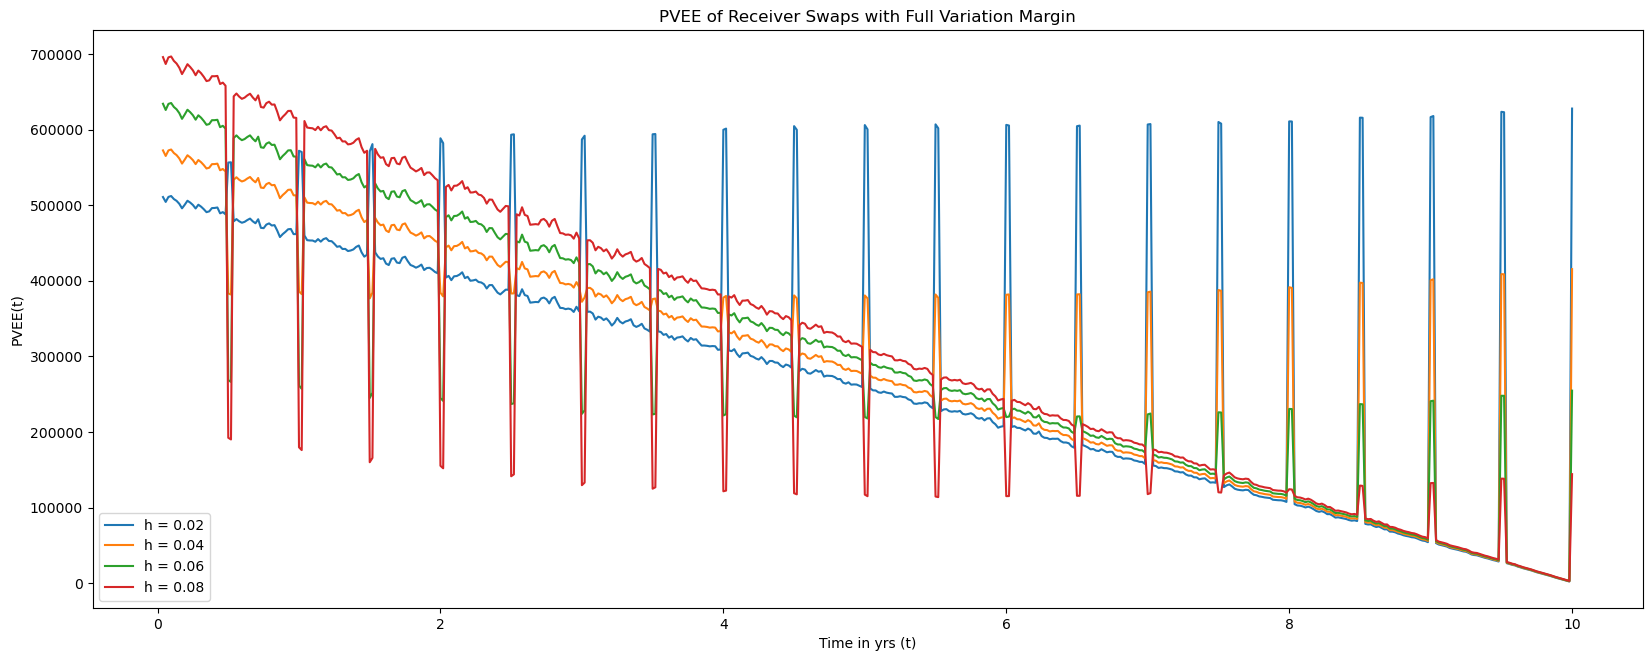

In [21]:
plt.figure(figsize=(20,7.5))
plt.title("PVEE of Receiver Swaps with Full Variation Margin")
plt.xlabel("Time in yrs (t)")
plt.ylabel("PVEE(t)")

for i in range(len(h1)):
    plt.plot(ts[2:], rPVEE_VM[i][2:], label= f'h = {h1[i]}')
    
plt.legend()
plt.show()

#### Scaling Approximation to find $EE$ with Initial Margin (IM):

$$EE_{IM}(t) \approx \Omega(p) . EE(t)$$

where $p=0.99, \Omega(p) \approx 1/117$

Now set the coupon on the swap equal to its par rate $h_{par}$ computed earlier. In addition to full variation margin, we also consider dynamic initial margin set at the confidence level $p$.

Using the above scaling approximation, we plot the $EE$ profile on a weekly grid for $p = 80\%, 90\%, 99\%, 99.9\%$. 
It suffices to do this for the payer swap.

In [22]:
p = np.array([0.8,0.9,0.99,0.999])

In [23]:
psi_p = (norm.pdf(norm.ppf(p)) - norm.ppf(p)*(1-p))*np.sqrt(2*np.pi)

In [24]:
swap_VM_IM = model3.SwapVal(x1_3,x2_3,h_par) * notional # Setting coupon = h_par
spvi = np.roll(swap_VM_IM, 2, axis=1)
swap_VM_IM_delta = spvi
pEE_VM_IM2 = np.zeros(len(p), dtype=object)
for i in range(len(p)):
    psi_p = (norm.pdf(norm.ppf(p[i])) - norm.ppf(p[i])*(1-p[i]))*np.sqrt(2*np.pi)
    pEE_VM_IM2[i] = np.mean(np.maximum(-(swap_VM_IM - swap_VM_IM_delta),0),axis=0) * psi_p  # Payer EE(t)

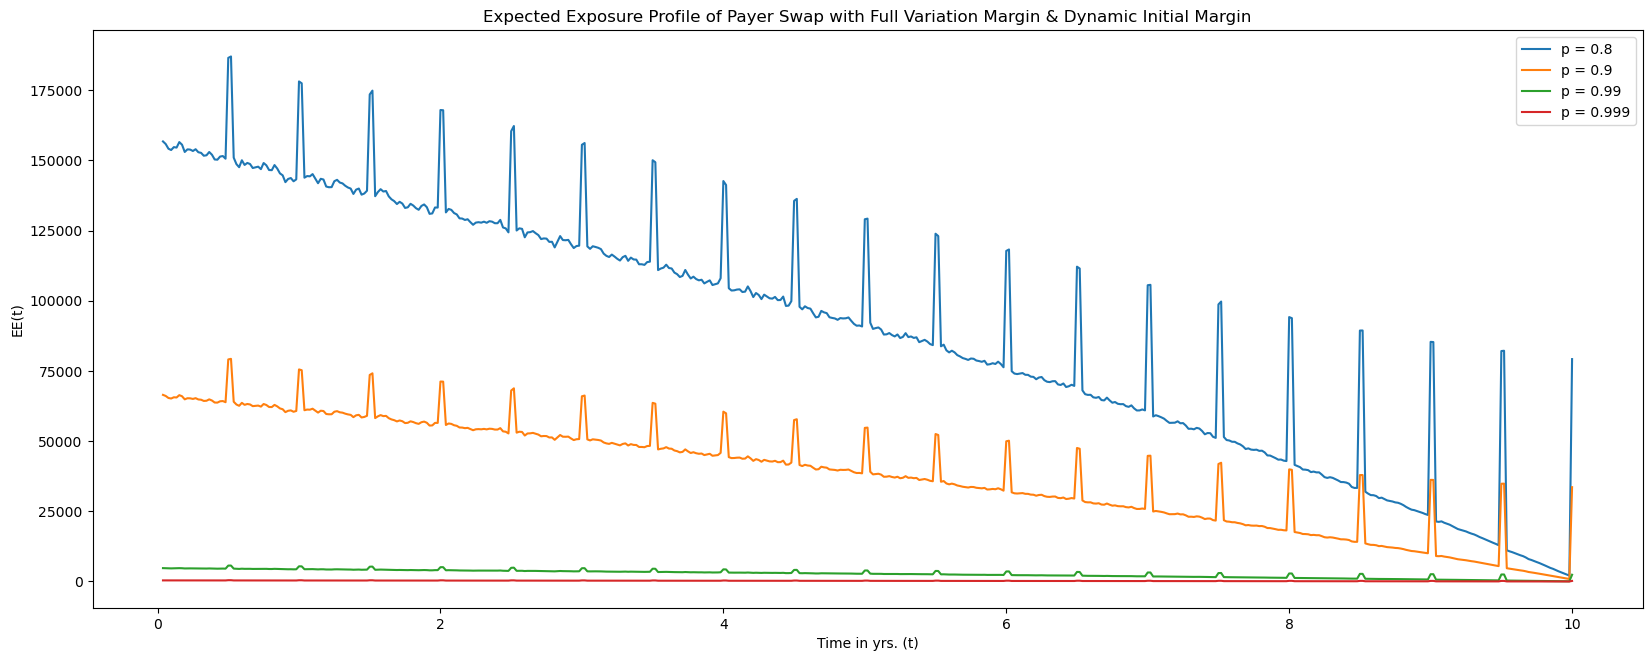

In [25]:
plt.figure(figsize=(20,7.5))
plt.title("Expected Exposure Profile of Payer Swap with Full Variation Margin & Dynamic Initial Margin")
plt.xlabel("Time in yrs. (t)")
plt.ylabel("EE(t)")

for i in range(len(p)):
    plt.plot(ts[2:],pEE_VM_IM2[i][2:], label=f'p = {p[i]}')

plt.legend()
plt.show()

**Assume that the swap is traded between a bank $B$ and client $A$. Suppose that the default intensity of $B$ is constant at $\lambda_{B} = 2\%$, and the default intensity of $A$ is constant at $\lambda_{A} = 4.5\%$. Assume that $B$ and $A$ both have recovery rates of $40\%$. We take the perspective of $B$.**

First, let's compute $B$’s unilateral CVA to $A$ for both payer and receiver swaps, at coupon rates of $h = 2\%, h = 4\%, h = 6\%, h = 8\%$. We do this with i) no collateral; ii) full variation margin; and iii) full variation margin and initial margin at level $p = 99\%$. As before, use a MPoR of $0.5$ months. 

## Credit Valuation Adjustment (CVA)
**CVA is the downard (negative) adjustment to the market value of the derivative instruments to account for counterparty credit (default) risk.**

### Unilateral CVA

Assuming B can never itself default, but that A has default risk and will default at time $\tau_{A}$, B will have an exposure $E^{+}(t)$ at $t=\tau_{A} + \delta$. We then define the B's unilateral CVA as -  

$$CVA_{U} = (1-R_{A}) \int_{0}^{T_{max}}\mathop{\mathbb{E}}\left( E^{+}(s+\delta)e^{-\int_{0}^{s+\delta}r(u)du}\lambda_{A}(s)e^{-\int_{0}^{s}\lambda_{A}(u)du} \right)$$

For practical computations, if the MPoR is short and the default is independent of the exposure, while working on a discrete time grid, the expression for CVA that can be used - 

$$CVA_{U} = - (1-R_{A})\int_{0}^{T_{max}}PVEE^{+}(s).\frac{\partial X_{A}(0,s)}{\partial s}ds$$

where $\frac{\partial X_{A}(0,s)}{\partial s} = X_{A}(0,s)-X_{A}(0,s+ds)$

$X_{A}(0,t)$ being the survival probability curve for A.

For practical computations, we can use the expression - 
$$CVA_{U} \approx -(1-R_{A})\sum_{i=0}^{N}PVEE^{+}(t_{i}).\{X_{A}(0,t_{i}) - X_{A}(0,t_{i-1})\}$$

In [26]:
# Survival Probability
def X(lmbd,t,T):
    return np.exp(-lmbd*(T-t))

# CVA
def CVA(pPVEEvec, rPVEEvec, lA, lB, R, ts_, calc_type='unilateral'):
    pCVA = np.zeros((len(pPVEEvec), len(ts_)))
    rCVA = np.zeros((len(rPVEEvec), len(ts_)))
    XB = 1
    
    for i in range(2,len(ts_)):
        dXA = X(lA,0,ts[i]) - X(lA,0,ts[i-1])
        if calc_type == 'bilateral':
            XB = X(lB,0,ts_[i])
        pCVA[:,i] = pPVEEvec[:,i] * dXA * XB
        rCVA[:,i] = rPVEEvec[:,i] * dXA * XB
    pCVA *= -1*(1-R)
    rCVA *= -1*(1-R)
    return np.sum(pCVA, axis=1), np.sum(rCVA, axis=1)

In [27]:
# Client A
lambdaA = 0.045 # Default Intensity
RA      = 0.4   # Recovery Rate

# Bank B
lambdaB = 0.02  # Default Intensity
RB      = 0.4   # Recovery Rate

In [28]:
Uni_pCVA = pd.DataFrame({'Coupon':['2%','4%','6%','8%'], 
                    'No Collateral': CVA(pPVEE,rPVEE,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[0], 
                    'VM': CVA(pPVEE_VM,rPVEE_VM,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[0], 
                    'VM + IM': CVA(pPVEE_VM_IM,rPVEE_VM_IM,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[0]})
Uni_pCVA = Uni_pCVA.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
print("Unilateral CVA Values for Payer Swap for different scenarios: ")
Uni_pCVA

Unilateral CVA Values for Payer Swap for different scenarios: 


No Collateral        VM  VM + IM
Coupon                                  
2%       1,085,664.56 63,134.26   536.27
4%         483,577.38 70,489.92   598.75
6%         195,670.40 78,855.33   669.81
8%          74,736.19 88,072.10   748.09

In [29]:
Uni_rCVA = pd.DataFrame({'Coupon':['2%','4%','6%','8%'], 
                    'No Collateral': CVA(pPVEE,rPVEE,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[1], 
                    'VM': CVA(pPVEE_VM,rPVEE_VM,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[1], 
                    'VM + IM': CVA(pPVEE_VM_IM,rPVEE_VM_IM,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[1]})
Uni_rCVA = Uni_rCVA.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
print("Unilateral CVA Values for Receiver Swap for different scenarios: ")
Uni_rCVA

Unilateral CVA Values for Receiver Swap for different scenarios: 


No Collateral        VM  VM + IM
Coupon                                  
2%         212,699.44 65,224.51   554.02
4%         589,117.38 66,656.21   566.19
6%       1,279,715.51 69,097.65   586.92
8%       2,137,286.42 72,390.46   614.89

### Bi-lateral CVA

Let us now focus on calculating B's bilateral CVA, i.e. how the default of B affect the losses it suffers from the default of A.

Note that, if B defaults before A, B will not suffer any loss from A’s default, as B is no longer around when A defaults.

The stochastic exposure for a default of A at time $\tau_{A}$ with settlement at $t=\tau_{A}+\delta$ is -

$$Y(t) = (1-R_{A})E^{+}(t)1_{\tau_{B}>t-\delta}$$

A full expression for the bilateral CVA is obtained as - 

$$CVA_{Bi} \approx -(1-R_{A})\int_{0}^{T_{max}}PVEE^{+}(s).X_{B}(0,s).\frac{\partial X_{A}(0,s)}{\partial s} ds$$

For practical computations we can use the expression,

$$CVA_{Bi} \approx -(1-R_{A})\sum_{i=0}^{N} PVEE^{+}(t_{i}).X_{B}(0,t_{i}).\{X_{A}(0,t_{i})-X_{A}(0,t_{i-1})\}$$

**Note that, $CVA_{U} \geq CVA_{Bi}$ since we incorporate the default probability $(0 \leq P(B) \leq 1)$ of B in the later expression.**

****

## Debit Valuation Adjustment (DVA)

The CVA formulas compute the PV of the credit losses B will suffer on a default of A. We could, however, also easily have taken the perspective of A and asked what A′s CVA to B was. From B’s perspective, A’s CVA is known as the Debit Valuation Adjustment (DVA).

Where CVA is a cost to B,the DVA is a gain to B. **DVA basically measures the benefit of being able to default one’s way out of trouble. It follows that B must make a gain when its rating deteriorates.**

The symmetrical definitions for DVA are as follows - 

$$DVA_{U} \approx -(1-R_{B})\int_{0}^{T_{max}}PVEE^{-}(s).\frac{\partial X_{B}(0,s)}{\partial s} ds$$

$$DVA_{Bi} \approx -(1-R_{B})\int_{0}^{T_{max}}PVEE^{-}(s).X_{A}(0,s).\frac{\partial X_{B}(0,s)}{\partial s} ds$$

The true value of a portfolio after accounting for credit losses is -

$$V_{true} = V(0) + DVa - CVA$$

Remember that,

$$CVA_{U} \geq CVA_{Bi} \; \; \& \; \; DVA_{U} \geq DVA_{Bi}$$

In [30]:
Bi_pCVA = pd.DataFrame({'Coupon':['2%','4%','6%','8%'], 
                    'No Collateral': CVA(pPVEE,rPVEE,lambdaA,lambdaB,RA,ts,calc_type='bilateral')[0], 
                    'VM': CVA(pPVEE_VM,rPVEE_VM,lambdaA,lambdaB,RA,ts,calc_type='bilateral')[0], 
                    'VM + IM': CVA(pPVEE_VM_IM,rPVEE_VM_IM,lambdaA,lambdaB,RA,ts,calc_type='bilateral')[0]})
Bi_pCVA = Bi_pCVA.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
print("Bilateral CVA Values for Payer Swap for different scenarios: ")
Bi_pCVA

Bilateral CVA Values for Payer Swap for different scenarios: 


No Collateral        VM  VM + IM
Coupon                                  
2%       1,010,868.28 59,225.46   503.07
4%         443,446.86 66,140.34   561.80
6%         176,624.51 73,976.17   628.36
8%          66,559.94 82,584.48   701.48

In [31]:
Bi_rCVA = pd.DataFrame({'Coupon':['2%','4%','6%','8%'], 
                    'No Collateral': CVA(pPVEE,rPVEE,lambdaA,lambdaB,RA,ts,calc_type='bilateral')[1], 
                    'VM': CVA(pPVEE_VM,rPVEE_VM,lambdaA,lambdaB,RA,ts,calc_type='bilateral')[1], 
                    'VM + IM': CVA(pPVEE_VM_IM,rPVEE_VM_IM,lambdaA,lambdaB,RA,ts,calc_type='bilateral')[1]})
Bi_rCVA = Bi_rCVA.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
print("Bilateral CVA Values for Receiver Swap for different scenarios: ")
Bi_rCVA

Bilateral CVA Values for Receiver Swap for different scenarios: 


No Collateral        VM  VM + IM
Coupon                                  
2%         194,240.73 61,033.85   518.43
4%         547,851.87 62,549.75   531.31
6%       1,202,062.08 64,986.61   552.00
8%       2,013,030.06 68,195.94   579.26

#### Observations:
* The magnitude of CVA (for uni- and bi-lateral calculations) decreases drastically as more collateral is introduced. This is because our Expected Exposure is less due to introduction of margin.
* Our Expected Exposure increases with increasing coupon rate (as visible in above plots), the increased credit risk thereby increases the value of CVA

As seen in the exposure profile, the payer has the most exposure at a 2% coupon and the least at a 8% coupon. The receiver is the opposite, with the most exposure at a 8% coupon and the least at 2%. The CVA value is proportional to the expected positive exposure of the trade. Including variation margin, the exposure of the trade to the forward two week period is significantly reduced ; moreover, the receiver and payer have similar exposure profiles. With Initial Margin, CVA is reduced to a very small amount as expected.

*****

## Funding Valuation Adjustment (FVA)

Funding valuation adjustment (FVA) reflects the funding cost of uncollateralised derivatives above the risk-free rate of return. It represents the costs and benefits of writing a hedge for a client who is not posting collateral, and then hedging that trade with a collateralised one in the interbank market.

The most common way to explain funding costs and benefits is as follows - 

A party such as a bank trading an uncollateralised derivative will hedge it with transaction(s) that will typically be collateralised due to being transacted with other banks bilaterally or in an exchange/CCP environment. This is because banks aim to run mainly flat (hedged) derivatives books. 

Consider what happens when the bank has a positive MTM on the client transaction(s): the hedge(s) will have an offsetting negative value and the bank will need to post collateral to cover this amount. The return paid on the collateral will typically be the OIS rate. Hence, unless the bank can fund the collateral they post at the OIS rate, then there will be an associated cost (negative FVA). The cost above OIS of borrowing the collateral to post should therefore be considered. 

On the other hand, when the bank has a negative MTM on the client transaction(s), they will receive collateral from the hedge(s), which creates a funding benefit (positive FVA) they have effectively borrowed money at the OIS rate.

A key key point to note is that, irrespective of the way FVA is defined, exposure drives a funding cost, just as it drives CVA. By symmetry, negative exposure drives a funding benefit analogous (or perhaps identical) to DVA.

Hence, CVA and FCA (Funding Cost Adjustment) are related to positive exposure, while DVA and FBA (Funding Benefit Adjustment) are related to negative exposure

#### Side Note:
OIS (overnight indexed swap) is generally the (unsecured) interest rate that large banks use to borrow and lend from one another in the overnight market. Some example of OIS rates are:
* Fed Funds (US Federal Reserve Overnight Rate)
* EONIA (Euro Overnight Index Average)
* SONIA (Sterling Overnight Index Average)
* MUTAN (Japanese Uncollateralised Overnight Call Rate)

Collateral arrangements involve parties posting cash or securities to mitigate counterparty risk, usually governed under the terms of an ISDA Credit Support Annex (CSA). The standard frequency of posting is daily and the holder of collateral typically pays an overnight interest rate such as EONIA or Fed Funds.

There are conceptual similarities between OIS and LIBOR rates. Both are unsecured and whilst the former reflects a single-day time horizon, the latter is longer (e.g. three months). Furthermore, OIS rates are averages from actual transactions whereas LIBOR is just the average (with the highest and lowest submissions removed) of banks’ stated opinions.

### FVA calculations

$$FVA = E \left( \int_{0}^{min(\tau,T_{max})} V(t)S(t)e^{-\int^{0}_{t}r(u)du} \right) dt$$

where, 
$S(t)$: Spread of the bank (Cost of raising funds for the collateral above the OIS).

We know that, 
$$FVA = FCA - FBA$$

$$FCA = \int_{0}^{T_{max}} E \left( S_{B}(t)V(t)^{+}e^{-\int^{0}_{t}\lambda_{B}(u)du}e^{-\int^{0}_{t}r(u)du} \right) dt$$

$$FBA = \int_{0}^{T_{max}} E \left( S_{B}(t)V(t)^{-}e^{-\int^{0}_{t}\lambda_{B}(u)du}e^{-\int^{0}_{t}r(u)du} \right) dt$$

Assuming $S_{B}$ and $\lambda_{B}$ are independent of $V$ and $r$,

$$FCA = \int_{0}^{T_{max}}PVEE^{+}(t)E\left(S_{B}(t)e^{-\int_{0}^{t}\lambda_{B}(u)du}\right)dt$$
$$FBA = \int_{0}^{T_{max}}PVEE^{-}(t)E\left(S_{B}(t)e^{-\int_{0}^{t}\lambda_{B}(u)du}\right)dt$$

If $S_{B}(t)$ is deterministic, we can write the expression as 
$$E\left(S_{B}(t)e^{-\int_{0}^{t}\lambda_{B}(u)du}\right) = S_{B}(t)X_{B}(0,t)$$

where $X_{B}(0,t)$ is B's survival probability to time $t$.

**We now turn to FVA and MVA computations. Let the credit spread of bank B be constant at $s_{B} = 1.2\%$. We recall that positions with full VM is associated with no FVA, so we only need to compute FVA for the uncollateralized swap; it is zero for the collateralized swaps. MVA is associated with positions that have initial margin.**

**Let us compute B’s FVA for the uncollateralized swap position, for both payer and receiver swaps for $h = 2\%, h = 4\%, h = 6\%, h = 8\%$.**

In [32]:
def FVA(pPVEEvec,rPVEEvec,ts_,lB,spread):
    FCA = np.zeros((len(pPVEEvec),len(ts_)))
    FBA = np.zeros((len(pPVEEvec),len(ts_)))
    
    for i in range(2,len(ts_)):
        FCA[:,i] = rPVEEvec[:,i] * spread * X(lB,0,ts_[i]) * (ts_[i]-ts_[i-1])
        FBA[:,i] = pPVEEvec[:,i] * spread * X(lB,0,ts_[i]) * (ts_[i]-ts_[i-1])
        
    return np.sum(FCA,axis=1) - np.sum(FBA,axis=1)

In [33]:
SB = 0.012

In [34]:
B_FVA = pd.DataFrame({'Coupon':['2%','4%','6%','8%'], 
                    'Payer': FVA(pPVEE,rPVEE,ts,lambdaB,SB), 
                    'Receiver': -1*FVA(pPVEE,rPVEE,ts,lambdaB,SB)})
B_FVA = B_FVA.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
print("FVA Values for Payer & Receiver Swap for B: ")
B_FVA

FVA Values for Payer & Receiver Swap for B: 


Payer    Receiver
Coupon                        
2%     -422,887.35  422,887.35
4%       47,370.22  -47,370.22
6%      517,627.80 -517,627.80
8%      987,885.38 -987,885.38

* FVA values are negative when FBA > FCA, i.e. essentially when B is receiving funding from its counterparty (short derivative). This is visible when the coupon rate is lesser than h
* For example, if B to entice B to enter a receiver swap at 2% coupon when the hpar is 3.4%, the counterparty has to pay B to conduct this trade (basically compensate). Using this cash B can theoretically extinguish its outstanding debt. Hence funding cost will be less than funding benefit
* The inverse would be true if we are paying a coupon lower than hpar or we were the receiver in the swap described above. The payer FVA and receiver FVA change between positive and negative values above the hpar rate because of the cost of carry on the trade

*****

## Margin Valuation Adjustment (MVA)

Margin valuation adjustment allows for the funding costs of the **Initial Margin (IM)** posted for a derivatives trade. This can apply to cleared trades, which require initial margin, and non-cleared trades, where initial margin requirements are being phased in over time. The central counterparty basis is also a form of MVA.

One can also think of MVA as - **FVA originating with IM postings**.

Let $IM(t)$ be the initial margin posted at time $t$. This $IM(t)$ amount becomes our exposure $V(t)$. We can then define the expression -

$$MVA = \int_{0}^{T_{max}}E\left( IM(t)S_{B}(t)e^{-\int_{0}^{t}\lambda_{B}(u)du}e^{-\int_{0}^{t}r(u)du} \right) dt$$

If $S_{B}$ is deterministic, under suitable assumptions ,we have - 

$$MVA = \int_{0}^{T_{max}}PVEIM(t)S_{B}(t)X_{B}(0,t)dt$$

Using the scaling approach defined eariler, we can write

$$PVEIM(t) = \sqrt{2\pi}\Phi^{-1}(p)PVEE^{*}(t)$$

where $PVEE^{*}$ is the PV-ed Expected Exposure profile without IM.

Using the above result, 

$$MVA = \sqrt{2\pi}\Phi^{-1}(p) \int_{0}^{T_{max}}PVEE^{*}(t)S_{B}(t)X_{B}(0,t)dt$$

$$MVA \approx -\sqrt{2\pi}\Phi^{-1}(p)(1-R_{B}) \int_{0}^{T_{max}}PVEE^{*}(t)\frac{\partial{X_{B}(0,t)}}{\partial t}dt$$

**Using the above scaling result, we compute MVA for the swap with full VM and IM at level $p = 99\%$ for both payer and receiver swaps with $h = 2\%, h = 4\%, h = 6\%, h = 8\%$. Let us also check if the drop in CVA from the introduction of IM justifies the MVA cost to B's shareholders.**

In [35]:
def MVA(pPVEEvec,rPVEEvec,ts_,lB,spread):
    pMVA = np.zeros((len(pPVEEvec),len(ts_)))
    rMVA = np.zeros((len(rPVEEvec),len(ts_)))
    
    for i in range(1,len(ts_)):
        pMVA[:,i] = pPVEEvec[:,i] * spread * X(lB,0,ts_[i]) * (ts_[i]-ts_[i-1])
        rMVA[:,i] = rPVEEvec[:,i] * spread * X(lB,0,ts_[i]) * (ts_[i]-ts_[i-1])
    
    scale_factor = (norm.ppf(0.99)) * np.sqrt(2 * np.pi)
    return np.sum(pMVA,axis=1)*scale_factor, np.sum(rMVA,axis=1)*scale_factor 

In [36]:
B_MVA = pd.DataFrame({'Coupon':['2%','4%','6%','8%'], 
                    'Payer': MVA(pPVEE_VM,rPVEE_VM,ts,lambdaB,SB)[0], 
                    'Receiver': MVA(pPVEE_VM,rPVEE_VM,ts,lambdaB,SB)[1]})
B_MVA = B_MVA.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
print("MVA Values for Payer & Receiver Swap for B: ")
B_MVA

MVA Values for Payer & Receiver Swap for B: 


Payer   Receiver
Coupon                      
2%     186,134.60 184,217.02
4%     198,373.42 190,588.02
6%     221,971.53 208,318.29
8%     248,075.79 228,554.73

* The shareholder's MVA cost is **not** justifiable to bring down the CVA value since the magnitude of decrease in the CVA values is less than the magnitude of MVA. In order to reduce CVA from roughly ten thousands to hundreds an MVA charge of roughly $\$180,000$ has been created. The MVA ends up being over ~360x greater than the CVA with variation margin and initial margin (at $p=99\%$); this is difficult to justify on economic terms, but is required by regulation.

****

A short summary of all the Valuation Adjustments - 

* **Credit Valuation Adjustment (CVA):** The negative adjustment for the counterparty risk due to the non-collateralised exposure in the event of the default of the counterparty. 

* **Debit Valuation Adjustment (DVA):** The positive adjustment for the counterparty risk due to the non-collateralised negative exposure in the event of own default. 

* **Funding Valuation Adjustment (FVA):** The adjustment for the costs and benefits arising from funding the MTM of a transaction due to imperfect collateralisation.

* **Margin Valuation Adjustment (MVA):** The negative adjustment as a result of the need to post initial margin against bilateral or centrally cleared transactions. This may also include the need to post default funds to a central counterparty, which could be termed “default fund VA” (although we will consider default fund costs as part of MVA). 

* **Capital Valuation Adjustment (KVA):** The negative adjustment as a result of the need (for banks) to hold regulatory capital against transactions to the extent that they are imperfectly collateralised (according to the capital methodology used).